# CIFAR 100_Project

## CIFAR 100 VS CIFAR 10

### 1. 기본적인 차이점
#### 클래스 수
- CIFAR-10 : 10개 클래스
- CIFAR-100 : 100개 클래스 -> 모델 출력층을 100개로 설정해야함
#### 2. 이미지 특성
- 공통점: 둘 다 32x32x3 컬러 이미지
- 차이점: 클래스 세분화 정도
#### 3. 난이도 차이
**CIFAR-100 특성**
- 세밀한 구분: 100종류의 동물, 차량, 가구 등
- 훨씬 어려움: 같은 모델로 20-30% 수준
- 데이터 부족: 클래스당 500개로 학습 어려움
#### 4. CIFAR-100의 추가 특징
*계층구조*
- CIFAR-100은 20개의 상위 클래스(superclass)를 가짐

*학습 난이도 요인*
1. 클래스 간 유사성: 비슷한 클래스 구분이 어려움
2. 데이터 부족: 클래스당 500개는 딥러닝에 부족
3. 세밀한 특징 필요: 더 깊고 복잡한 모델 필요 

## 모델 개선 순서
1. 모델 구조 개선 (CNN)
2. Data Augmentation
3. Batch Norm/Dropout
4. Learning Rate
5. Optimzer 선택
6. Batch Size
7. Epochs 수
8. Weight Decay

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [2]:
# Data Augmentation 셀
import torchvision.transforms as transforms

# ========= Data Augmentation 설정 =========

# Training용 Transform (Augmentation 포함)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding= 4),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.5071, 0.4867, 0.4408],
        std = [0.2675, 0.2565, 0.2761]
    )
])

# Validation/ Test용 Transform (Augmentation 없음)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5071, 0.4867, 0.4408],
        std = [0.2675, 0.2565, 0.2761]
    )
])

print("✅ Data Augmentation transforms created")

✅ Data Augmentation transforms created


In [3]:
# CIFAR100 데이터셋 로드(Augmentation 적용)

# Train 데이터 (Augmentation 적용)
cifar100_train_aug = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= train_transform # Augmentation 적용
)

# Validation 데이터 (Augmentation 없음)
cifar100_train_no_aug = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= test_transform # Augmentation 없음
)

# Train / Validation 분할
# 시드 고정 추가
torch.manual_seed(42)
train_dataset, _ = random_split(cifar100_train_aug, [40000, 10000])

torch.manual_seed(42)
_, val_dataset = random_split(cifar100_train_no_aug, [40000, 10000])

# Test 데이터
test_dataset = datasets.CIFAR100(
    root= './data',
    train= False,
    download= True,
    transform= test_transform
)

# 시각화용 원본 데이터
cifar100_dataset = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= transforms.ToTensor()
)

print("Data loaded with Augmentation(seed=42)")
print(f"    Train: {len(train_dataset)} (with augmentation)")
print(f"    Val: {len(val_dataset)} (no augmentation)")
print(f"    Test: {len(test_dataset)} (no augmentation)")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Data loaded with Augmentation(seed=42)
    Train: 40000 (with augmentation)
    Val: 10000 (no augmentation)
    Test: 10000 (no augmentation)


In [4]:
# DataLoader (batch 단위로 데이터 공급)
device = torch.device("cpu")
print(f"Using device: {device}")

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    #추가
    num_workers=0,      
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    # 추가
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    # 추가
    num_workers=0
)

Using device: cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.7106762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..2.0011694].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.826505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.6953943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.256214].


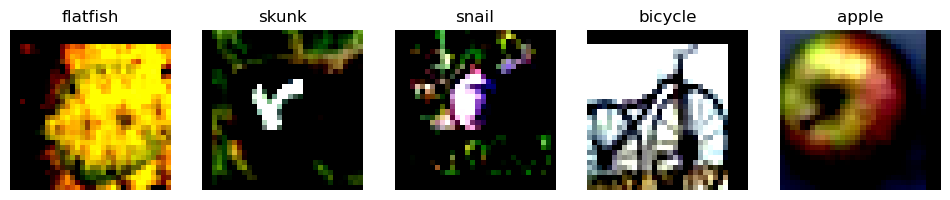

In [5]:
import matplotlib.pyplot as plt

# 데이터 확인: train_loader에서 샘플 몇 개 가져오기
classes = cifar100_dataset.classes  # ['airplane', 'automobile', ..., 'truck']

plt.figure(figsize=(12, 3))
for i in range(5):
    img, label = train_dataset[i]
    np_img = img.numpy().transpose((1, 2, 0))
    plt.subplot(1, 5, i+1)
    plt.imshow(np_img)
    plt.title(classes[label])
    plt.axis('off')
plt.show()


In [6]:
############# TODO: 모델 선언하기 (주의: 이미지 크기 달라짐)
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding= 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding= 1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding= 1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 100)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 4 * 4)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [7]:
########### 학습 할 때 마다 해당 셀 꼭 다시 실행하기!!!! ###########

############# TODO: 모델 생성, 손실함수, 옵티마이저 정의하기
model = ImprovedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode= 'max',
    factor= 0.5,
    patience= 5
    )

# Early Stopping 설정
best_val_acc= 0
patience= 10
patience_counter= 0
best_model_state= None

In [8]:
import time

num_epochs = 40
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    # ---- Training ----
    model.train()  # 학습 모드
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)        
        loss = criterion(outputs, labels)           
        loss.backward()              
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()  # 평가 모드
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)       
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_acc = correct / len(val_dataset)
    val_loss /= len(val_loader)

    # Learning Rate Scheduling
    old_lr = optimizer.param_groups[0]['lr']    # 변경 전 LR 저장
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']    # 변경 후 LR

    if current_lr != old_lr:
        print(f"\n LR reduced: {old_lr:.6f} -> {current_lr:.6f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        status = "Best"
    else:
        patience_counter += 1
        status = f"({patience_counter}/{patience})"

        if patience_counter >= patience:
            print(f"\n Early Stopping at Epoch {epoch + 1}")
            break
    
    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time

    print(f"Epoch [{epoch+1:2d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} {status}"
          f"\nLR: {current_lr:.6f} [{epoch_time:.1f}s, {elapsed/60:.1f}min]")

# 최고 모델 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nMode; restored to best state")

total_time = time.time() - start_time
print(f"\n Training complete in {total_time/60:.1f}minutes")
print(f"Best Val Accuracy: {best_val_acc:.4f}")


Epoch [ 1/40] Train Loss: 4.0121, Train Acc: 0.0789 | Val Loss: 3.4694, Val Acc: 0.1618 Best
LR: 0.001000 [39.3s, 0.7min]
Epoch [ 2/40] Train Loss: 3.4846, Train Acc: 0.1560 | Val Loss: 3.0688, Val Acc: 0.2317 Best
LR: 0.001000 [38.2s, 1.3min]
Epoch [ 3/40] Train Loss: 3.2297, Train Acc: 0.2030 | Val Loss: 2.8704, Val Acc: 0.2711 Best
LR: 0.001000 [40.1s, 2.0min]
Epoch [ 4/40] Train Loss: 3.0707, Train Acc: 0.2299 | Val Loss: 2.7309, Val Acc: 0.3041 Best
LR: 0.001000 [41.4s, 2.6min]
Epoch [ 5/40] Train Loss: 2.9674, Train Acc: 0.2501 | Val Loss: 2.6800, Val Acc: 0.3101 Best
LR: 0.001000 [37.6s, 3.3min]
Epoch [ 6/40] Train Loss: 2.8964, Train Acc: 0.2621 | Val Loss: 2.6459, Val Acc: 0.3235 Best
LR: 0.001000 [43.0s, 4.0min]
Epoch [ 7/40] Train Loss: 2.8259, Train Acc: 0.2732 | Val Loss: 2.4693, Val Acc: 0.3577 Best
LR: 0.001000 [43.2s, 4.7min]
Epoch [ 8/40] Train Loss: 2.7676, Train Acc: 0.2893 | Val Loss: 2.5037, Val Acc: 0.3571 (1/10)
LR: 0.001000 [42.3s, 5.4min]
Epoch [ 9/40] Train Lo

In [9]:
# ---- Test ----
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)       ######### TODO: forward pass
        loss = criterion(outputs, labels)           ######### TODO: loss(error) 계산하기
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_dataset)
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.8671, Test Accuracy: 0.4918


In [10]:
# Confusion Matrix 생성
from sklearn.metrics import confusion_matrix
import numpy as np

# 모델의 모든 예측 수집
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # CPU로 이동 후 numpy 배열로 변환
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)

# 확인
print(f"Confusion Matrix Shape: {cm.shape}")  # (100, 100)
print(f"Total Samples: {cm.sum()}")  # 10000
print(f"Correct Predictions: {np.diag(cm).sum()}")

Confusion Matrix Shape: (100, 100)
Total Samples: 10000
Correct Predictions: 4918


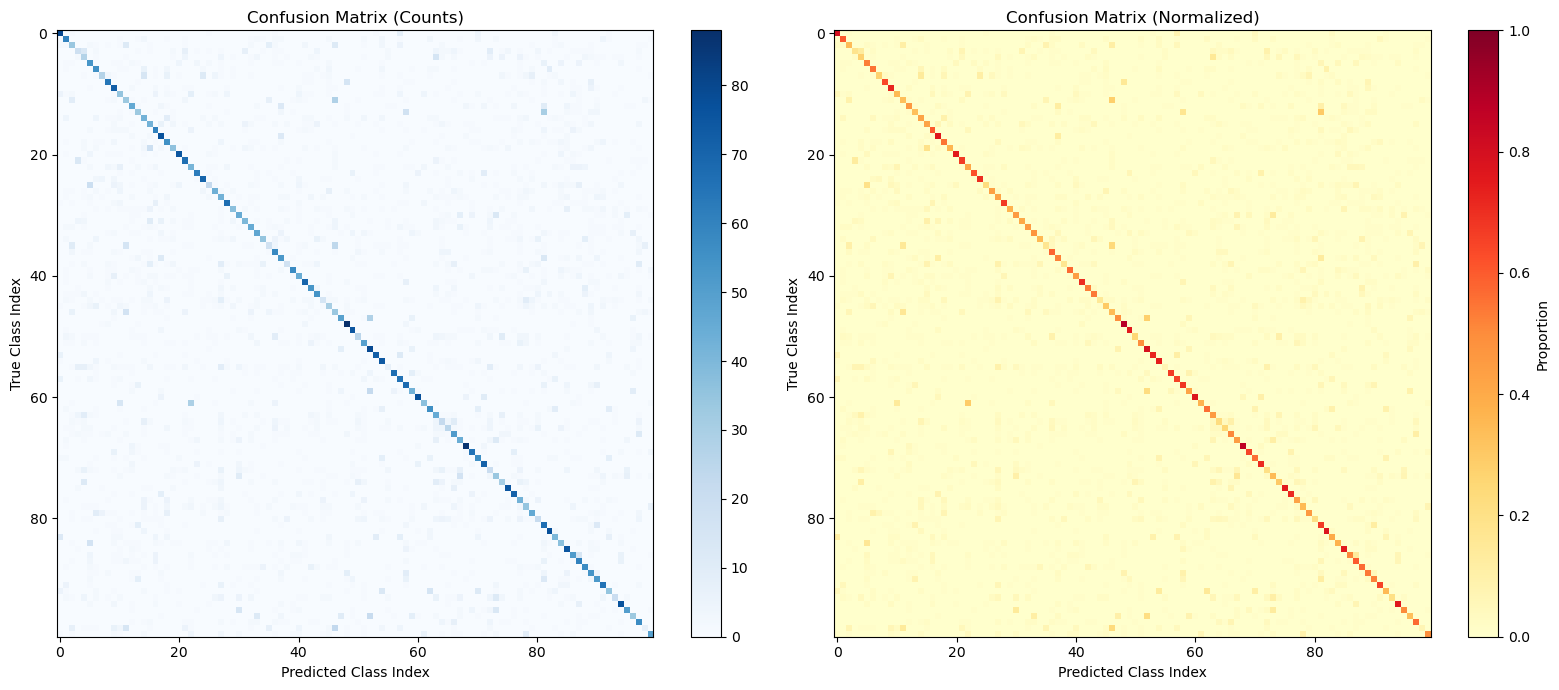

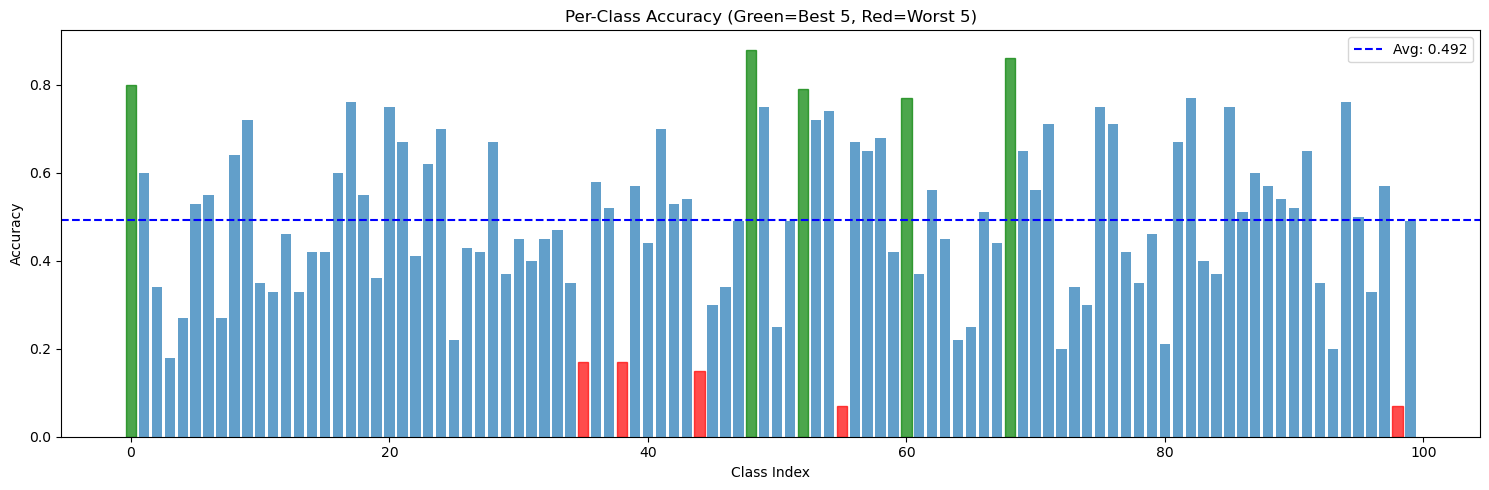

In [11]:
# 시각화 하기
import matplotlib.pyplot as plt
# 1) 전체 히트맵 (레이블 없이)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 원본 카운트
im1 = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted Class Index')
axes[0].set_ylabel('True Class Index')
plt.colorbar(im1, ax=axes[0])

# 정규화 버전
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im2 = axes[1].imshow(cm_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted Class Index')
axes[1].set_ylabel('True Class Index')
plt.colorbar(im2, ax=axes[1], label='Proportion')

plt.tight_layout()
plt.show()

# 2) 클래스별 정확도 바 차트
class_acc = np.diag(cm) / cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(range(100), class_acc, alpha=0.7)

# 상위/하위 5개 강조
top_5 = np.argsort(class_acc)[-5:]
bottom_5 = np.argsort(class_acc)[:5]
for idx in top_5:
    bars[idx].set_color('green')
for idx in bottom_5:
    bars[idx].set_color('red')

ax.axhline(y=class_acc.mean(), color='blue', linestyle='--', 
           label=f'Avg: {class_acc.mean():.3f}')
ax.set_xlabel('Class Index')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy (Green=Best 5, Red=Worst 5)')
ax.legend()
plt.tight_layout()
plt.show()